In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from models.deepLOB.deepLOB_model import Deeplob
from models.transLOB.transLOB_model import TransLOB

from utils.fi2010_loader import Dataset_fi2010

In [2]:
model_names = ["deeplob", "translob"]
normalizations = ["Zscore", "DecPre"] # "MinMax"
horizons = [3,4] #[0, 1, 2, 3, 4]
dataset_type = "fi2010"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:

# Dummy mapping from model name to constructor (replace with actual imports)
def get_model_class(name):
    if name == "deeplob":
        return Deeplob
    elif name == "translob":
        return TransLOB
    else:
        raise ValueError("Unknown model name")

# Dummy function to create test_loader (you must implement this)
def create_test_loader(model_name, normalization, k):
    from utils.fi2010_loader import Dataset_fi2010
    stock = [0]#, 1, 2, 3, 4]
    days = [8, 9, 10]
    T = 100
    unsqueeze = True if model_name=="deeplob" else False
    dataset_test = Dataset_fi2010(False, normalization, stock, days, T, k, unsqueeze, False)
    return DataLoader(dataset=dataset_test, batch_size=128, shuffle=False, num_workers=4)
    # return dataset_test
    # return torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False, num_workers=4)

# Evaluation logic
def evaluate_model(model_class, model_name, normalization, k, test_loader):
    path = f"./outputs/{dataset_type}/{model_name}_{normalization}_{k}.pth"
    if not os.path.exists(path):
        print(f"Model not found: {path}, skipping...")
        return {
            "accuracy": np.nan,
            "f1": np.nan,
            "precision": np.nan,
            "recall": np.nan
        }

    model = model_class()
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()

    all_y_true, all_y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_y_true.append(y_batch.cpu().numpy())
            all_y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
    }

In [6]:
results = []

for model_name in model_names:
    for normalization in normalizations:
        for k in horizons:
            print(f"Evaluating {model_name} | {normalization} | k={k}")
            test_loader = create_test_loader(model_name, normalization, k)
            model_class = get_model_class(model_name)
            metrics = evaluate_model(model_class, model_name, normalization, k, test_loader)

            results.append({
                "model": model_name,
                "normalization": normalization,
                "horizon_k": k,
                **metrics
            })
            # print(results)

Evaluating deeplob | Zscore | k=3
Model not found: ./outputs/fi2010/deeplob_Zscore_3.pth, skipping...
Evaluating deeplob | Zscore | k=4
Evaluating deeplob | DecPre | k=3
Model not found: ./outputs/fi2010/deeplob_DecPre_3.pth, skipping...
Evaluating deeplob | DecPre | k=4
Model not found: ./outputs/fi2010/deeplob_DecPre_4.pth, skipping...
Evaluating translob | Zscore | k=3
Model not found: ./outputs/fi2010/translob_Zscore_3.pth, skipping...
Evaluating translob | Zscore | k=4
Evaluating translob | DecPre | k=3
Model not found: ./outputs/fi2010/translob_DecPre_3.pth, skipping...
Evaluating translob | DecPre | k=4
Model not found: ./outputs/fi2010/translob_DecPre_4.pth, skipping...


In [9]:
results_df = pd.DataFrame(results)
results_df

,model,normalization,horizon_k,accuracy,f1,precision,recall
0,deeplob,Zscore,3,NaN,NaN,NaN,NaN
1,deeplob,Zscore,4,0.530519,0.407694,0.446351,0.414053
2,deeplob,DecPre,3,NaN,NaN,NaN,NaN
3,deeplob,DecPre,4,NaN,NaN,NaN,NaN
4,translob,Zscore,3,NaN,NaN,NaN,NaN
5,translob,Zscore,4,0.543446,0.418279,0.441368,0.413267
6,translob,DecPre,3,NaN,NaN,NaN,NaN
7,translob,DecPre,4,NaN,NaN,NaN,NaN


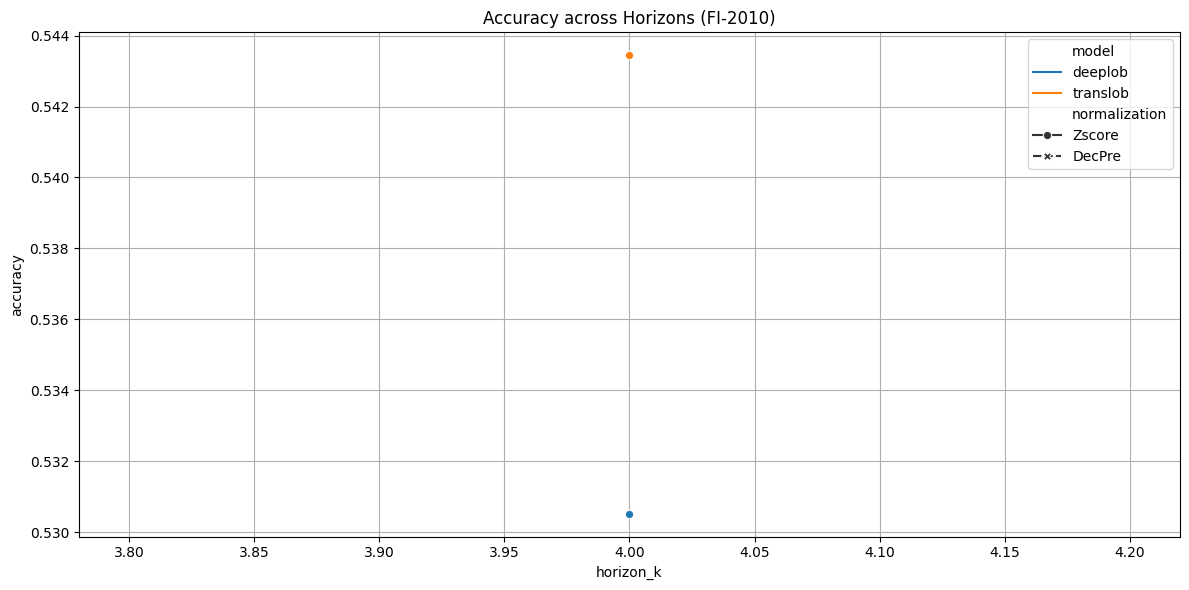

In [8]:

# results_df.to_csv("./outputs/fi2010_model_results.csv", index=False)

# Plot example: Accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="horizon_k", y="accuracy", hue="model", style="normalization", markers=True)
plt.title("Accuracy across Horizons (FI-2010)")
plt.grid(True)
plt.tight_layout()
plt.show()
